In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
ed.set_seed(42)


In [17]:
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 400    # number of classes.
alpha = 1.0

In [18]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w_0 = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b_0 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
w_1 = Normal(loc=tf.zeros([K, K]), scale=tf.ones([K, K]))
b_1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))

# Categorical likelihood for classication.
y = Categorical(tf.matmul(tf.matmul(x,w_0)+b_0,w_1)+b_1)

In [19]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw_0 = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb_0 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
qw_1 = Normal(loc=tf.Variable(tf.random_normal([K, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K, K])))) 
qb_1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [20]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
# inference = ed.KLqp({w: qw_0, b: qb}, data={y:y_ph})
inference = ed.BB_alpha({w_0: qw_0, w_1: qw_1, b_0: qb_0, b_1: qb_1}, data={y: y_ph})

In [32]:
# Initialse the infernce variables
inference.initialize(n_iter=20000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

In [33]:

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [34]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)


20000/20000 [100%] ██████████████████████████████ Elapsed: 101s | Loss: 1704983.750


In [24]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [25]:
ttt = qw_0.sample()
print(ttt)

Tensor("Normal_12/sample_1/Reshape:0", shape=(784, 400), dtype=float32)


In [26]:
# w_0_samp = qw_0.sample()
# b_0_samp = qb_0.sample()
# w_1_samp = qw_1.sample()
# b_1_samp = qb_1.sample()
    
# w_0_samples.append(w_0_samp)
# b_0_samples.append(b_0_samp)
# w_1_samples.append(w_1_samp)
# b_1_samples.append(b_1_samp)

In [27]:
# flf = tf.nn.softmax(tf.matmul(tf.matmul( X_test.astype('float32'),w_0_samp ) + b_0_samp,w_1_samp)+b_1_samp)
# flf

In [30]:

# Generate samples the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w_0_samples = []
b_0_samples = []
w_1_samples = []
b_1_samples = []
for _ in range(n_samples):
    w_0_samp = qw_0.sample()
    b_0_samp = qb_0.sample()
    w_1_samp = qw_1.sample()
    b_1_samp = qb_1.sample()
    
    w_0_samples.append(w_0_samp)
    b_0_samples.append(b_0_samp)
    w_1_samples.append(w_1_samp)
    b_1_samples.append(b_1_samp)
    
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul(tf.matmul( X_test.astype('float32'),w_0_samp ) + b_0_samp,w_1_samp)+b_1_samp)
    prob_lst.append(prob.eval())
    #sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    #samples.append(sample.eval())

Text(0,0.5,'Frequency')

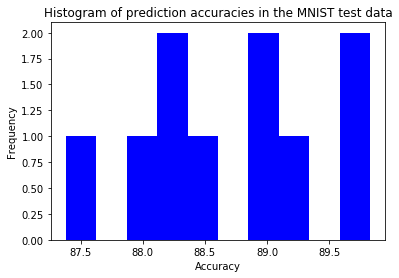

In [31]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test,color='b')
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

In [26]:
Y_test

array([7, 2, 1, ..., 4, 5, 6])

In [24]:
ed.evaluate('categorical_accuracy', data={y: Y_test, x: X_test})

0.086199999

In [15]:
np.savetxt('test.out', accy_test, delimiter=',')   # X is an array

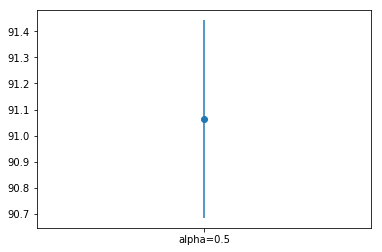

In [14]:
x=['alpha=0.5']
y=np.mean(accy_test)
e=np.sqrt(np.var(accy_test))
plt.errorbar(x, y, yerr=e, fmt='o')
plt.show()

### Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)